<a href="https://colab.research.google.com/github/partizanos/advanced_image_processing/blob/master/AEI_tp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tp4 image processing JPEG -- DIMITRIS PROIOS



## Notes 
On every of the steps of the exercise I made some comments and tried to encode and decode it.

**For step1 : 
- Implement by yourself the JPEG compression algorithm described above.**

I did all the steps on the encoding in the decoding I had some issues and I didn't imlement the reverse of zig zag.
I had also  problems in dct, quantization.
That said prior to that it is working fine and I managed to encode and decode it until that point 

**For step2 and 3  
(b)Take a colour image test.png. Compress this image by your JPEG algorithm implemen-
tation. (c) Perform the image reconstruction.**

In every step I compress and reconstruct the image . Apart from the ones having problems and apart from quantization step that is not reversible.

For step 4:
**(d) Display the original and reconstructed images. Compare those images based on the MSE.
Make a conclusion about the compression efficiency based on the visual images quality
and the files size.**


I know form theory jpeg is a lossy algorithm and it can also receive parameter for how much compretion rate we want.
the compression rate is embedded in the Z matrix we saw.
In general it was very interseting TP even though I failed to do it to perfection.

I expect that the higher compression rate we choose with our Z matrix we will have and higher MSE.

I also expect that JPEG since it performs quantization will always have losses. So there will be never values of 0 MSE.


## Exercise 1 (a) Implement by yourself the JPEG compression algorithm described above.
### 1.Color space transformation :
#### RGB color space to YCbCr color space conversion:



First, the image should be converted from RGB into a different color space called Y′CBCR (or, informally, YCbCr). 

It has three components: 
- the Y' component represents the brightness of a pixel, 
- CB and CR components represent the chrominance (split into blue and red components). 

The Y′CBCR color space conversion allows greater compression without a significant effect on perceptual image quality (or greater perceptual image quality for the same compression).

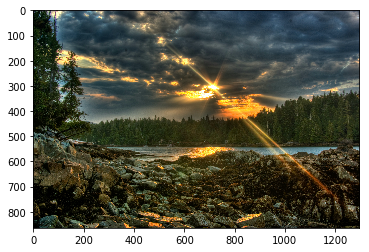

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import math
from scipy import fftpack 



response = requests.get("https://raw.githubusercontent.com/partizanos/advanced_image_processing/master/TP/TP4/test.png")
imRaw = Image.open(BytesIO(response.content))
img = np.array(imRaw)
M, N, _ = img.shape
max_M = int(math.modf(M/8)[1] *8)
max_N = int(math.modf(N/8)[1] *8)
crop = lambda img:img[:max_M, :max_N, :]
im = crop(img )

def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

# test
plt.imshow(ycbcr2rgb(rgb2ycbcr(im)))

In [2]:
def extract_colors(img):
  R_DIMENSION = img[:, :, 0]
  G_DIMENSION = img[:, :, 1]
  B_DIMENSION = img[:, :, 2]
  return R_DIMENSION, G_DIMENSION, B_DIMENSION

y, cb, cr = extract_colors(im)
y.shape, cb.shape, cr.shape 

((864, 1296), (864, 1296), (864, 1296))

### 2.  Downsampling 

#### Keep the Y component. and downsample the Cb and Cr components in 2 times.


- Due to color and brightness densities, humans can see considerably more fine detail in the brightness of an image (the Y' component)  than in the hue and color saturation of an image (the Cb and Cr components). Using this knowledge, encoders can be designed to compress images more efficiently.


- The transformation into the Y′CBCR color model enables reduce the spatial resolution of the Cb and Cr components (called "downsampling" or "chroma subsampling"). The ratios at which the downsampling is ordinarily done for JPEG images are: 
  - 4:4:4 (no downsampling)
  - 4:2:2 (reduction by a factor of 2 in the horizontal direction), 
  - (most commonly) 4:2:0 (reduction by a factor of 2 in both the horizontal and vertical directions). 

For the rest of the compression process, Y', Cb and Cr are processed separately and in a very similar manner.

(864, 1296, 3)


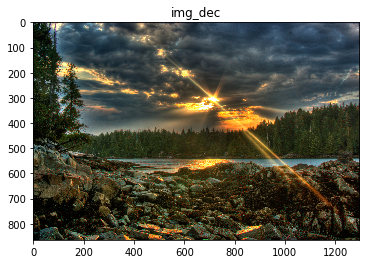

In [3]:
# https://pillow.readthedocs.io/en/latest/handbook/concepts.html#concept-filters
import PIL 

def downsample(img):
  
  y, cb, cr = extract_colors(im)
  img = PIL.Image.fromarray(cb)
  img = img.resize((648, 432),resample=0)

  cb = np.array(img)

  img = PIL.Image.fromarray(cr)
  img = img.resize((648, 432))

  cr = np.array(img)
  return y, cb, cr 

def upsample(y,cb,cr):
  img = PIL.Image.fromarray(cb)
  img = img.resize((1296, 864),resample=0)

  cb = np.array(img)

  img = PIL.Image.fromarray(cr)
  img = img.resize(( 1296, 864))
  cr = np.array(img)
  
  return np.stack((y, cb, cr), axis=-1)


# 
img = np.array(imRaw)
M, N, _ = img.shape
max_M = int(math.modf(M/8)[1] *8)
max_N = int(math.modf(N/8)[1] *8)
crop = lambda img:img[:max_M, :max_N, :]
im = crop(img )
print(im.shape)

img_enc  = rgb2ycbcr(im)
y, cb, cr = downsample(img_enc)

img_dec = upsample(y, cb, cr )
plt.imshow(img_dec);  plt.title("img_dec"); plt.show()

# test
# plt.imshow(y);  plt.title("y"); plt.show()
# plt.imshow(cr);  plt.title("cr"); plt.show()
# plt.imshow(cb); plt.title("cb"); plt.show()

# img_dec = ycbcr2rgb(ups)

# plt.imshow(img_dec); plt.show()
# img_dec.shape
# ups[0].shape
# ups=ups.reshape((864, 1296, 3))


### 3. Preprocessing for DCT transformation

#### 3.1 Split the image into 8 × 8 non-overlapping blocks

(864, 1296, 3)


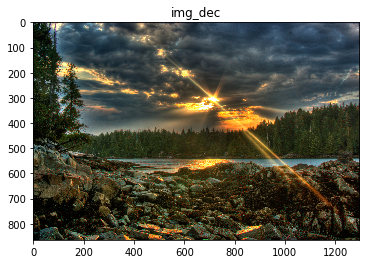

In [4]:
def img_2_block(Y, cb, cr, number_octads):
  number_octads = int(max_M* max_N / 64)
  number_octads_reduced = int(max_M/2* max_N/2 / 64)
  Y_r = Y.reshape((number_octads, 8,8))
  Cb_r = cb.reshape((number_octads_reduced, 8,8))
  Cr_r = cr.reshape((number_octads_reduced, 8,8))
  return Y_r, Cb_r,Cr_r
  
def block_2_img(y, cb, cr):
  Y_r = y.reshape((864, 1296))
  Cb_r = cb.reshape((int(864/2), int(1296/2)))
  Cr_r = cr.reshape((int(864/2), int(1296/2)))
  return Y_r, Cb_r,Cr_r
  
  
# test TODO grayscale image 
#test
#   Y_r[0] = [
#       [52, 55, 61, 66, 70, 61, 64, 73],
#       [63, 59, 66, 90, 109, 85, 69, 72],
#       [62, 59, 68, 113, 144, 104, 66, 73],
#       [63, 58, 71, 122, 154, 106, 70, 69],
#       [67, 61, 68, 104, 126, 88, 68, 70],
#       [79, 65, 60, 70, 77, 63, 58, 75],
#       [85, 71, 64, 59, 55, 61, 65, 83],
#       [87, 79, 69, 68, 65, 76, 78, 94]
#   ]






img = np.array(imRaw)
M, N, _ = img.shape
max_M = int(math.modf(M/8)[1] *8)
max_N = int(math.modf(N/8)[1] *8)
crop = lambda img:img[:max_M, :max_N, :]
im = crop(img )
print(im.shape)

# encoding 
img_enc  = rgb2ycbcr(im)
y, cb, cr = downsample(img_enc)
y, cb, cr= img_2_block(y, cb, cr, (max_M, max_N ) )

# decoding 

y, cb, cr = block_2_img(y, cb, cr)
img_dec = upsample(y, cb, cr )
plt.imshow(img_dec);  plt.title("img_dec"); plt.show()

#### 3.2 In each block subtract global mean computed as 2 k−1 , where k is the number of gray levels in the image

(864, 1296, 3)


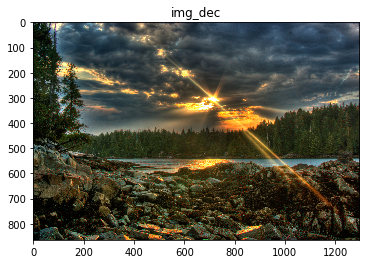

In [5]:
def global_mean_reduce(y,cb,cr):
  global_mean = 128
  y = y  - global_mean
  cb = cb  - global_mean
  cr = cr  - global_mean
  return y, cb, cr

def global_mean_add(y,cb,cr):
  global_mean = 128
  y = y  + global_mean
  cb = cb  + global_mean
  cr = cr  + global_mean
  return y, cb, cr

img = np.array(imRaw)
M, N, _ = img.shape
max_M = int(math.modf(M/8)[1] *8)
max_N = int(math.modf(N/8)[1] *8)
crop = lambda img:img[:max_M, :max_N, :]
im = crop(img )
print(im.shape)

# encoding 
img_enc  = rgb2ycbcr(im)
y, cb, cr = downsample(img_enc)
y, cb, cr= img_2_block(y, cb, cr, (max_M, max_N ) )
y, cb, cr= global_mean_reduce(y,cb,cr)
  
# decoding 
y, cb, cr= global_mean_add(y,cb,cr)
y, cb, cr = block_2_img(y, cb, cr)
img_dec = upsample(y, cb, cr )
plt.imshow(img_dec);  plt.title("img_dec"); plt.show()



### Step 4. DCT transformation per block: T (u, v)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


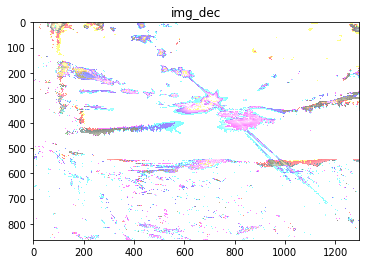

In [6]:
# TODO aply and inverse image should be same MSE =10** -10
def dct_2d(y, cb, cr):
  y = fftpack.dct(fftpack.dct(y.T, norm='ortho').T, norm='ortho')
  cb = fftpack.dct(fftpack.dct(cb.T, norm='ortho').T, norm='ortho')
  cr = fftpack.dct(fftpack.dct(cr.T, norm='ortho').T, norm='ortho')
  return y, cb, cr
  
def idct_2d(y, cb, cr): 
  y = fftpack.idct(fftpack.idct(y.T, norm='ortho').T, norm='ortho')
  cb = fftpack.idct(fftpack.idct(cb.T, norm='ortho').T, norm='ortho')
  cr = fftpack.idct(fftpack.idct(cr.T, norm='ortho').T, norm='ortho')
  return y, cb, cr
  


img = np.array(imRaw)
M, N, _ = img.shape
max_M = int(math.modf(M/8)[1] *8)
max_N = int(math.modf(N/8)[1] *8)
crop = lambda img:img[:max_M, :max_N, :]
im = crop(img )
# encoding 
img_enc  = rgb2ycbcr(im)
y, cb, cr = downsample(img_enc)
y, cb, cr= img_2_block(y, cb, cr, (max_M, max_N ) )
y, cb, cr= global_mean_reduce(y,cb,cr)
# print("before dct ")
# print(y[0, :10])
y, cb, cr = dct_2d(y, cb, cr)
# print(y[0, :10])
# print("after")
# print(y[0, :10])

# decoding 
y, cb, cr  = idct_2d(y, cb, cr )
# print(y[0, :10])

# print(y.shape, cb.shape, cr.shape)
y, cb, cr= global_mean_add(y,cb,cr)
y, cb, cr = block_2_img(y, cb, cr)
img_dec = upsample(y, cb, cr )
img_dec = img_dec.astype("uint")
# print(img_dec[0, :10])
# print(img_dec.shape)
plt.imshow(img_dec);  plt.title("img_dec"); plt.show()

### Step 5. Block coefficients quantization:

$T(u,v) = round \frac{T(u,v)} {Z(u,v)}  $

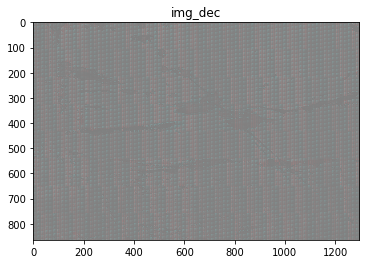

In [7]:
# inversible step

def quantization(Y_dct, Cb_dct, Cr_dct, Z):
  T_Y = np.round(Y_dct/Z)
  T_cb = np.round(Cb_dct/Z)
  T_cr = np.round(Cr_dct/Z)
  
  return (T_Y, T_cb, T_cb)
 
  
######################

Z = [
      [16, 11, 10, 16, 24, 40, 51, 61],
      [12, 12, 14, 19, 26, 28, 60, 55],
      [14, 13, 16, 24, 40, 57, 69, 56],
      [14, 17, 22, 29, 51, 87, 80, 62],
      [18, 22, 37, 56, 68, 109, 103, 77],
      [24, 35, 55, 64, 81, 104, 113, 92],
      [49, 64, 78, 87, 103, 121, 120, 101],
      [72, 92, 95, 98, 112, 100, 103, 99]
]


img = np.array(imRaw)
M, N, _ = img.shape
max_M = int(math.modf(M/8)[1] *8)
max_N = int(math.modf(N/8)[1] *8)
crop = lambda img:img[:max_M, :max_N, :]
im = crop(img )
# encoding 
img_enc  = rgb2ycbcr(im)
y, cb, cr = downsample(img_enc)
y, cb, cr= img_2_block(y, cb, cr, (max_M, max_N ) )
y, cb, cr= global_mean_reduce(y,cb,cr)
# commented for testing 
# y, cb, cr = dct_2d(y, cb, cr)
# non reversible step 
y, cb, cr = quantization(y, cb, cr, Z)

# decoding 
# commented for testing 
# y, cb, cr  = idct_2d(y, cb, cr )
y, cb, cr= global_mean_add(y,cb,cr)
y, cb, cr = block_2_img(y, cb, cr)
img_dec = upsample(y, cb, cr )
img_dec = img_dec.astype("uint")
plt.imshow(img_dec);  plt.title("img_dec"); plt.show()

### Step 6. Symbols encoding:
#### 6.1  Zig-zag scanning


In [0]:
# this is the sequence of zig zag scanning indices
# zig_zag_indices
# https://rosettacode.org/wiki/Zig-zag_matrix#Python
import operator
def get_zig_zag_indices(block_size=8):
  def zigzag(n):
      '''zigzag rows'''
      def compare(xy):
          x, y = xy
          return (x + y, -y if (x + y) % 2 else y)

      xs = range(n)

      return {index: n for n, index in enumerate(sorted(
          ((x, y) for x in xs for y in xs),
          key=compare
      ))}


  x = zigzag(block_size)
  zig_zag_indices = sorted(x.items(), key=operator.itemgetter(1))
  zig_zag_indices = [ i[0] for i in zig_zag_indices]
  return zig_zag_indices

(17496, 8, 8)


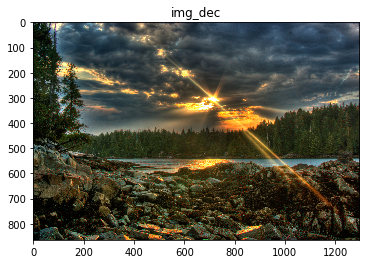

In [9]:
# zig zag representation

def zigzag_representation(y,cb,cr,zig_zag_indices):
  Y_zigzag = []
  cb_zigzag = []
  cr_zigzag = []
  for block in range(y):
    for i in zig_zag_indices:
      Y_zigzag.append(y[block][i])
      cb_zigzag.append(cb[block][i])
      cr_zigzag.append(cr[block][i])
  return Y_zigzag,cb_zigzag,cr_zigzag

def inverse_zigzag_representation(y,cb,cr,zig_zag_indices):
  Y_zigzag = []
  cb_zigzag = []
  cr_zigzag = []
  for block in range(y):
    for i in zig_zag_indices:
      Y_zigzag.append(y[block][i])
      cb_zigzag.append(cb[block][i])
      cr_zigzag.append(cr[block][i])
  return Y_zigzag,cb_zigzag,cr_zigzag
  
#################
# encoding 
img_enc  = rgb2ycbcr(im)
y, cb, cr = downsample(img_enc)
y, cb, cr= img_2_block(y, cb, cr, (max_M, max_N ) )
y, cb, cr= global_mean_reduce(y,cb,cr)

print(y.shape)


# commented for testing 
# y, cb, cr = dct_2d(y, cb, cr)
# non reversible step 
# commented for testing 
# y, cb, cr = quantization(y, cb, cr, Z)
# zig_zag_indices= get_zig_zag_indices(8)
# y,cb,cr = zigzag_representation(y,cb,cr) 

# y,cb,cr = inverse_zigzag_representation(y,cb,cr) 
# decoding 
# commented for testing 
# y, cb, cr  = idct_2d(y, cb, cr )
y, cb, cr= global_mean_add(y,cb,cr)
y, cb, cr = block_2_img(y, cb, cr)
img_dec = upsample(y, cb, cr )
img_dec = img_dec.astype("uint")
plt.imshow(img_dec);  plt.title("img_dec"); plt.show()

#### 6.2 Huffman coding

In [0]:
def get_freq(y,cb,cr):
  # count frequency of each color 
  def count_color_freq(img):
    unique, counts = np.unique(img, return_counts=True)
    return dict(zip(unique, counts))

  frequencies = [count_color_freq(chanel) for chanel in [y, cb, cr] ] 
  return frequencies


def get_probs(y,cb,cr):
  
  total_pixels = max_N *max_M
  
  frequencies = get_freq(y,cb,cr)
  # frequencies = [ { k:v/total_pixels for k,v in f.items()} for f in frequencies]
  probs = []
  for f_index in range(len(frequencies)):
    probs.append({ k:v/total_pixels for k,v in frequencies[f_index].items()})
  return probs

In [0]:
# https://gist.github.com/mreid/fdf6353ec39d050e972b
# Example Huffman coding implementation
# Distributions are represented as dictionaries of { 'symbol': probability }
# Codes are dictionaries too: { 'symbol': 'codeword' }

def huffman(p):
    '''Return a Huffman code for an ensemble with distribution p.'''
    assert(sum(p.values()) > 0.90) # Ensure probabilities sum to 1
    assert(sum(p.values()) < 1.1) # Ensure probabilities sum to 1

    # Base case of only two symbols, assign 0 or 1 arbitrarily
    if(len(p) == 2):
        return dict(zip(p.keys(), ['0', '1']))

    # Create a new distribution by merging lowest prob. pair
    p_prime = p.copy()
    a1, a2 = lowest_prob_pair(p)
    p1, p2 = p_prime.pop(a1), p_prime.pop(a2)
    p_prime[a1 + a2] = p1 + p2

    # Recurse and construct code on new distribution
    c = huffman(p_prime)
    ca1a2 = c.pop(a1 + a2)
    c[a1], c[a2] = ca1a2 + '0', ca1a2 + '1'

    return c

def lowest_prob_pair(p):
    '''Return pair of symbols from distribution p with lowest probabilities.'''
    assert(len(p) >= 2) # Ensure there are at least 2 symbols in the dist.

    sorted_p = sorted(p.items())
    return sorted_p[0][0], sorted_p[1][0]

# Example execution
# ex1 = { 'a': 0.5, 'b': 0.25, 'c': 0.25 }
# huffman(ex1) # => {'a': '0', 'c': '10', 'b': '11'}
# huffmans = [huffman(f) for f in range(len(frequencies))]



# huffman_trees = [ huffman(probs[i]) for i in range(3)]
# 
probs = get_probs(y,cb,cr)
# huffman_trees = [ huffman(probs[i]) for i in range(3)]